In [1]:
import pandas as pd
import glob

files = [i for i in glob.glob(r'/workspaces/miniconda/PKdata/data/*.csv') if 'nca' not in i]

In [2]:

for f_idx, f in enumerate(files):
    if f_idx == 0:
        df_out = pd.read_csv(f)
        df_out = df_out[[i for i in df_out.columns if 'unnamed' not in i.lower()]]
        df_out['TIME'] = df_out['TIME'].astype(float)
    else:
        tmp = pd.read_csv(f)
        tmp = tmp[[i for i in tmp.columns if 'unnamed' not in i.lower()]]
        if 'TIME' in tmp.columns:
            tmp['TIME'] = df_out['TIME'].astype(float)
            merge_c = ['ID', 'TIME']
        else:
            merge_c = ['ID']
        df_out = df_out.merge(tmp, how = 'left', on = merge_c)
        

In [3]:
import numpy as np
from nca import estimate_subject_slope_cv, estimate_k_halflife
xth_df = df_out.loc[df_out['ANALYTE'] == 'xanthohumol', :].copy()


# K and Halflife (t_1/2)

In [4]:
dfs = []
for sub in xth_df['ID'].unique():
    dfs.append(estimate_subject_slope_cv(xth_df.loc[xth_df['ID'] == sub, :], conc_col='CONC'))

/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mea

In [5]:
_ = estimate_k_halflife(dfs)
# this still needs to be filtered to give one unique value of the geom mean per subject

<Axes: xlabel='TIME', ylabel='CONC'>

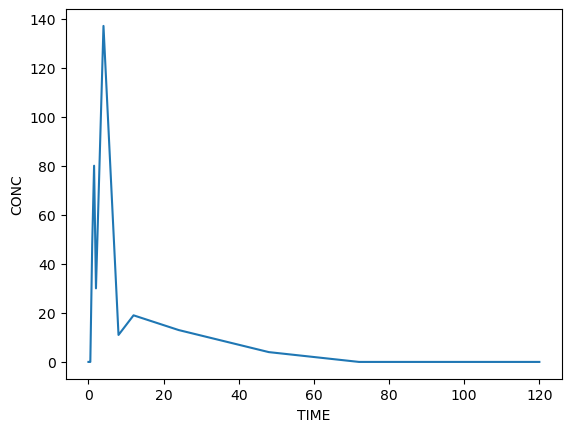

In [11]:
import seaborn as sns
from utils import safe_signed_log
from scipy.signal import savgol_filter

plot_me = xth_df.loc[(xth_df['ID'] == 'H11') & (xth_df['TIME'] < 200), :].copy()
plot_me['conc_ln'] = safe_signed_log(plot_me['CONC'])
sns.lineplot(plot_me, x = 'TIME', y = 'CONC',)


<Axes: xlabel='TIME', ylabel='CONC'>

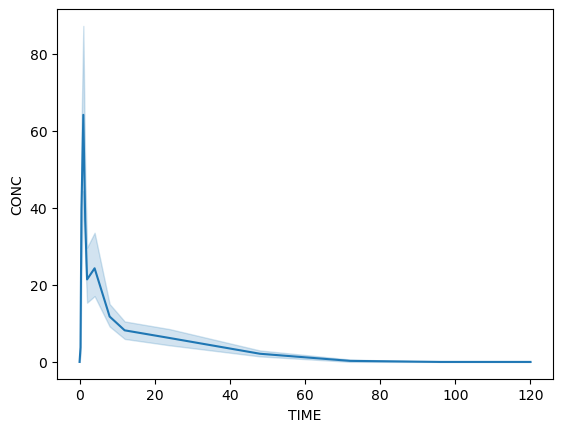

In [14]:
import seaborn as sns


sns.lineplot(xth_df, x = 'TIME', y = 'CONC',)

# MRT

In [15]:
from sklearn.metrics import auc

In [16]:
xth_df['ConcTime'] = xth_df['CONC'] * xth_df['TIME']

In [17]:
auc_df = (xth_df
 .groupby('ID')[['TIME', 'CONC']]
 .apply(lambda x: auc(x['TIME'], x['CONC']))
 .reset_index()
 .rename(columns = {0:'AUC'})
 )

auc_df.head()


,ID,AUC
0,H1,941.875
1,H10,820.875
2,H11,1038.500
3,H12,899.125
4,H13,425.000


In [39]:
def log_trapazoidal_auc(time, conc):
    tmp_auc = ((np.diff(conc)
            /(np.diff(safe_signed_log(conc))+1e-6))
    *(np.diff(time)))
    tmp_auc[np.isnan(tmp_auc)] = 0
    return np.sum(tmp_auc)

In [40]:
lin_auc_up

25.625

In [33]:
linear_up

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,ConcTime
1092,H17,0.00,0,xanthohumol,NaN,NaN,M,0.0
1093,H17,0.25,0,xanthohumol,NaN,NaN,M,0.0
1094,H17,0.50,21,xanthohumol,NaN,NaN,M,10.5
1095,H17,1.00,71,xanthohumol,NaN,NaN,M,71.0


In [35]:
log_down

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,ConcTime
1095,H17,1.0,71,xanthohumol,NaN,NaN,M,71.0
1096,H17,1.5,38,xanthohumol,NaN,NaN,M,57.0
1097,H17,2.0,21,xanthohumol,180.0,oral,M,42.0
1098,H17,4.0,38,xanthohumol,NaN,NaN,M,152.0
1099,H17,8.0,12,xanthohumol,NaN,NaN,M,96.0
1100,H17,12.0,10,xanthohumol,NaN,NaN,M,120.0
1101,H17,24.0,6,xanthohumol,NaN,NaN,M,144.0
1102,H17,48.0,0,xanthohumol,NaN,NaN,M,0.0
1103,H17,72.0,0,xanthohumol,NaN,NaN,M,0.0
1104,H17,96.0,0,xanthohumol,NaN,NaN,M,0.0


In [43]:
#per subject, calculate AUC and AUMC
auc_df = []
for sub in xth_df['ID'].unique():
    work_df = xth_df.loc[xth_df['ID'] == sub, :]
    auc_out = auc(work_df['TIME'].values, work_df['CONC'].values)
    auc_mc = auc(work_df['TIME'].values, work_df['ConcTime'].values)
    t_of_max_c = work_df.loc[work_df['CONC'] == work_df['CONC'].max(), 'TIME'].values[-1]
    linear_up = work_df.loc[work_df['TIME'] <= t_of_max_c, :]
    log_down = work_df.loc[work_df['TIME'] >= t_of_max_c, :]
    lin_auc_up = auc(linear_up['TIME'].values, linear_up['CONC'].values)
    log_auc_down = log_trapazoidal_auc(log_down['TIME'].values, log_down['CONC'].values)
    linup_logdown_auc = lin_auc_up + log_auc_down
    auc_df.append({
        'ID':sub, 'AUC':auc_out,'linup_logdown_AUC': np.round(linup_logdown_auc, 3),'AUCMC':auc_mc
    })
auc_df = pd.DataFrame(auc_df)

In [44]:
auc_df

,ID,AUC,linup_logdown_AUC,AUCMC
0,L1,72.000,8.142500e+01,523.2500
1,L2,326.375,3.013170e+02,6615.4375
2,L3,84.125,9.799400e+01,545.8125
3,L4,12.500,1.181900e+01,13.5000
4,L5,185.750,1.774480e+02,1064.6250
5,L6,190.500,1.826430e+02,686.5000
6,L7,143.375,1.328350e+02,471.1875
7,L8,200.875,2.012010e+02,889.5625
8,L9,134.625,1.749930e+02,1428.1875
9,L10,25.875,3.111500e+01,58.6875


In [23]:
auc(work_df['TIME'].values, work_df['CONC'].values)

438.625

In [22]:
np.trapz(work_df['CONC'].values, work_df['TIME'].values)

438.625

In [19]:
#per subject calculate MRT
auc_df['MRT'] = auc_df['AUCMC']/auc_df['AUC']
auc_df

,ID,AUC,AUCMC,MRT
0,L1,72.000,523.2500,7.267361
1,L2,326.375,6615.4375,20.269437
2,L3,84.125,545.8125,6.488113
3,L4,12.500,13.5000,1.080000
4,L5,185.750,1064.6250,5.731494
5,L6,190.500,686.5000,3.603675
6,L7,143.375,471.1875,3.286399
7,L8,200.875,889.5625,4.428438
8,L9,134.625,1428.1875,10.608635
9,L10,25.875,58.6875,2.268116


# CL/F

In [16]:
auc_df = xth_df.merge(auc_df, how = 'left', on = 'ID')

In [17]:
auc_df

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,ConcTime,AUC,AUCMC,MRT
0,L1,0.00,0,xanthohumol,20.0,oral,M,0.0,72.000,523.2500,7.267361
1,L1,0.25,0,xanthohumol,NaN,NaN,M,0.0,72.000,523.2500,7.267361
2,L1,0.50,0,xanthohumol,NaN,NaN,M,0.0,72.000,523.2500,7.267361
3,L1,1.00,34,xanthohumol,NaN,NaN,M,34.0,72.000,523.2500,7.267361
4,L1,1.50,15,xanthohumol,NaN,NaN,M,22.5,72.000,523.2500,7.267361
...,...,...,...,...,...,...,...,...,...,...,...
667,H17,24.00,6,xanthohumol,NaN,NaN,M,144.0,438.625,4512.4375,10.287689
668,H17,48.00,0,xanthohumol,NaN,NaN,M,0.0,438.625,4512.4375,10.287689
669,H17,72.00,0,xanthohumol,NaN,NaN,M,0.0,438.625,4512.4375,10.287689
670,H17,96.00,0,xanthohumol,NaN,NaN,M,0.0,438.625,4512.4375,10.287689


In [ ]:
auc_df['dose_ug'] = auc_df['DOSE'] * 1000
auc_df['cl/f'] = auc_df['dose_ug']/auc_df['AUC']
clf_df = auc_df[['ID', 'cl/f']].dropna().copy()
clf_df #these are close, but the AUC I was calculating should 

,ID,cl/f
0,L1,277.777778
15,L2,61.279203
30,L3,237.741456
45,L4,1600.000000
60,L5,107.671602
75,L6,104.986877
90,L7,139.494333
105,L8,99.564406
120,L9,148.560817
135,L10,772.946860
